# Data Import and Overview

<small> df.info() provides a summary of the dataset, including data types and non-null counts.<br>
df.head() displays the first five rows, giving a glimpse of the data.</small>

In [1]:
import pandas as pd

df = pd.read_csv("CloudWatch_Traffic_Web_Attack.csv")
df.info
df.head(5)

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


# Data Preprocessing
<small>Missing values can skew analysis; we address them by filling or dropping.<br>
Converting time columns ensures accurate time-based computations.</small>

In [2]:
missing_value = df.isnull().sum()
print(missing_value)

bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64


# Exploratory Data Analysis (EDA)
<small>Histograms show the distribution of data, helping identify anomalies or skewness.<br>
Count plots reveal the frequency of each protocol used in the traffic.</small>

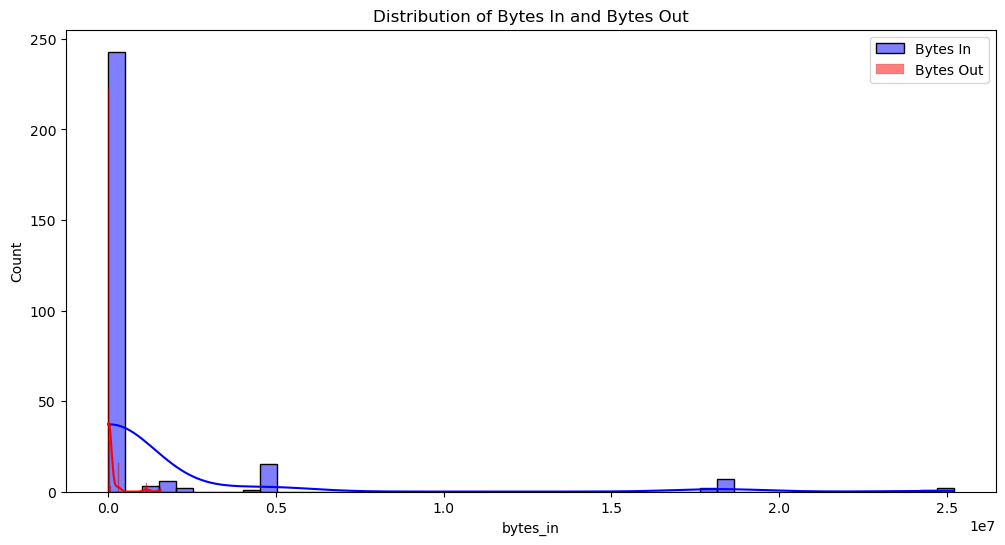

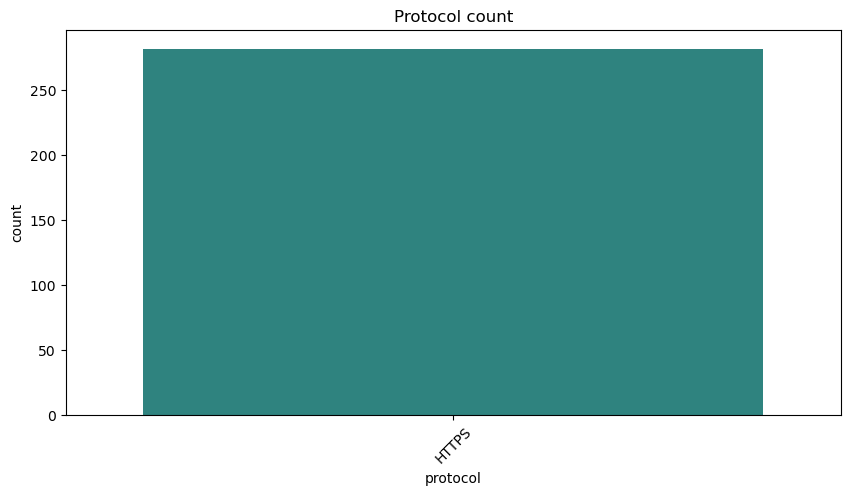

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.histplot(df["bytes_in"], bins = 50, color="blue", kde=True,label = "Bytes In")
sns.histplot(df["bytes_out"], bins = 50, color = "red", kde = True, label = "Bytes Out")
plt.legend()
plt.title("Distribution of Bytes In and Bytes Out")
plt.show


plt.figure(figsize=(10,5))
sns.countplot(x = "protocol", data = df,palette="viridis", hue = "protocol", legend=False)
plt.title("Protocol count")
plt.xticks(rotation = 45)
plt.show()


# Feature Engineering
<small>session_duration helps understand the length of each connection.<br>
avg_packet_size provides insight into data transfer efficiency.</small>

In [9]:
#Convert 'creation_time' and 'end_time' to datetime
df['creation_time'] = pd.to_datetime(df['creation_time'], errors='coerce')
df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')

print(df[['creation_time', 'end_time']].dtypes)


df['session_duration'] = (df['end_time'] - df['creation_time']).dt.total_seconds()
df["avg_packet_size"] = (df["bytes_in"] + df["bytes_out"])/df["session_duration"]

creation_time    datetime64[ns, UTC]
end_time         datetime64[ns, UTC]
dtype: object


# Data Visualization
<small>Identifying countries with high interaction counts can highlight potential threat sources.<br>
Analyzing destination ports associated with suspicious activities helps in understanding attack vectors.</small>

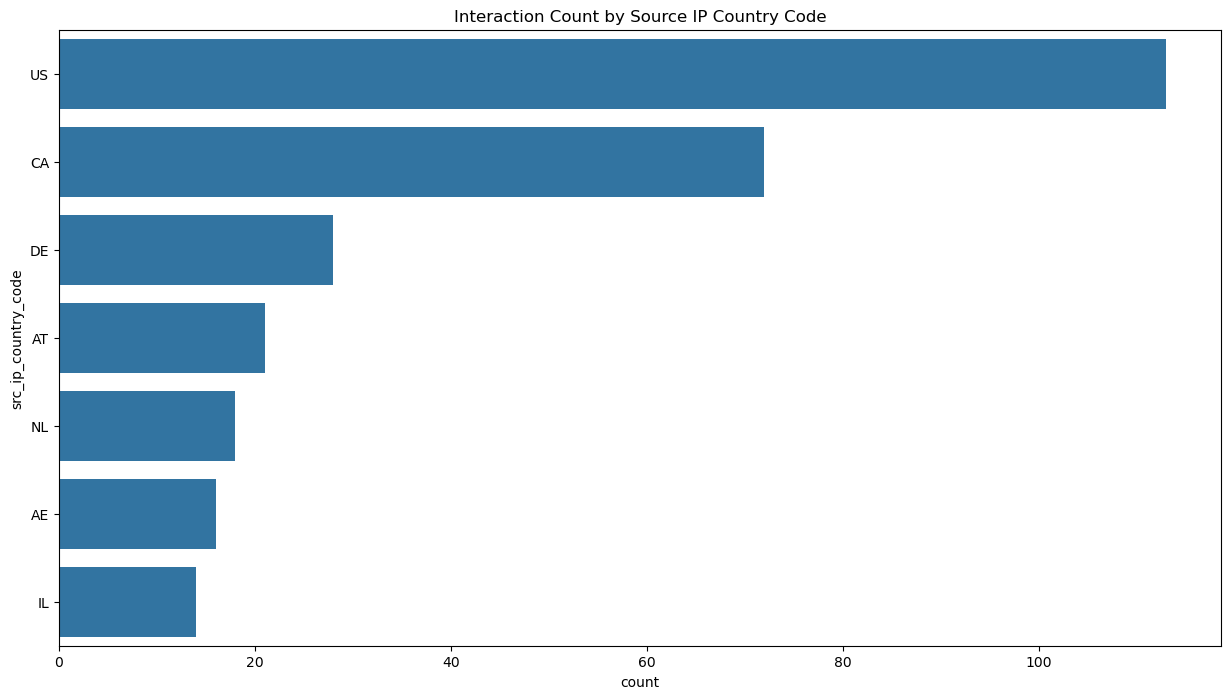

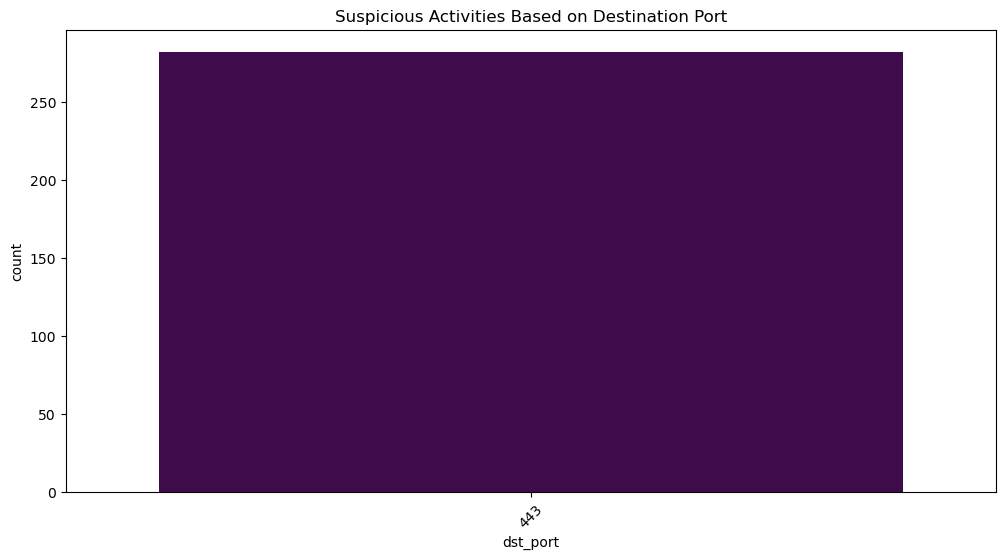

In [ ]:
plt.figure(figsize=(15,8))
sns.countplot(y ="src_ip_country_code", data = df, order = df["src_ip_country_code"].value_counts().index)
plt.title("Interaction Count by Source IP Country Code")
plt.show()

suspicious_df = df[df['detection_types'] == 'waf_rule']

plt.figure(figsize=(12, 6))
sns.countplot(x="dst_port", data=suspicious_df, palette="viridis", hue="dst_port", legend=False)
plt.title("Suspicious Activities Based on Destination Port")
plt.xticks(rotation=45)
plt.show()



# Modeling: Anomaly Detection
<small>Isolation Forest is effective for anomaly detection in high-dimensional datasets.<br>
The contamination parameter estimates the proportion of anomalies in the data.</small>

In [33]:
from sklearn.ensemble import IsolationForest

features = df[["bytes_in", "bytes_out", "session_duration", "avg_packet_size"]]

model = IsolationForest(contamination=0.05, random_state= 42)

df["anomaly"] = model.fit_predict(features)

df["anomaly"] = df["anomaly"].apply(lambda x: "Suspicious" if x == -1 else "Normal")
print(df['anomaly'].value_counts())

anomaly
Normal        267
Suspicious     15
Name: count, dtype: int64


The model successfully identified 15 suspicious activities out of 282 records, highlighting potential security threats. 

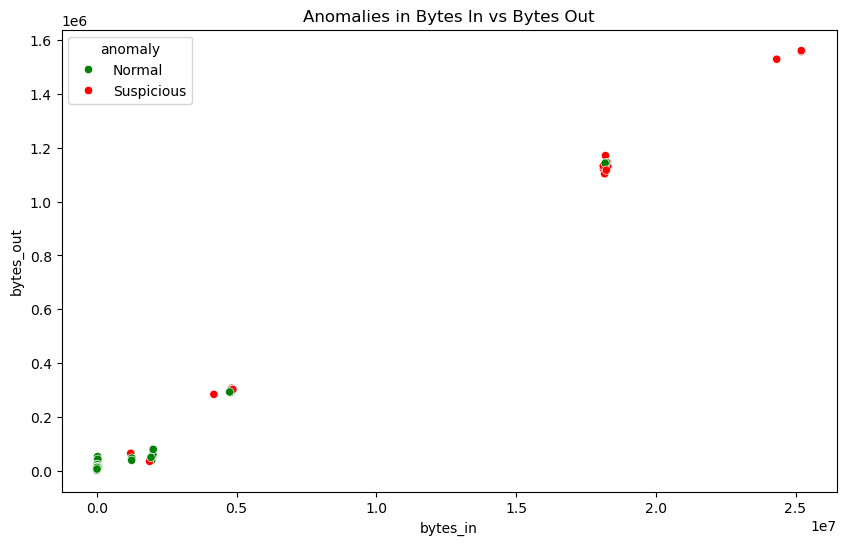

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x="bytes_in", y="bytes_out", hue="anomaly", data=df, palette={"Normal": "green", "Suspicious": "red"})
plt.title("Anomalies in Bytes In vs Bytes Out")
plt.show()